# Numerical differentiation of unequally sampled data using Machine Learning - 2nd derivative
- _Pascal Tribel - Machine Learning Group_
- _December 2024_
## Abstract
Derivative estimation is a fundamental problem in numerical analysis, scientific computing, and machine learning, with applications ranging from solving differential equations to data analysis in physics and engineering. Classical approaches to derivative estimation include finite difference methods, spline-based approximations, and spectral methods. These techniques, while effective in many settings, often face limitations when dealing with irregularly spaced (non-evenly discretized) input data, noise, or highly nonlinear functions.

Neural networks and neural operators have recently emerged as powerful tools for learning complex functional mappings. Neural operators, in particular, extend traditional neural network frameworks by operating in infinite-dimensional function spaces, making them highly suitable for learning mappings between functions. This framework has been successfully applied to problems such as solving partial differential equations (PDEs) (e.g., Fourier neural operators) and emulating physical systems. However, the application of neural operators for derivative estimation has not been thoroughly explored, especially for irregularly spaced input intervals.

Since the differentiation is commonly formulated using the operator paradigm, but the task can also be defined in the functional paradigm when facing sampled data, we define a framework to compare the performances of different Machine Learning architecture, while comparing them to classical numerical solvers.
## Problem statement
The entire processus is the same as in `Derivative.ipynb`, but the goal now is to approximate the 2nd derivative.
## Code
### Libraries import

!pip install torch_harmonics symengine

In [2]:
import numpy as np
import torch
import torch.nn as nn
import neuralop
from neuralop.models import FNO1d
import matplotlib.pyplot as plt
import seaborn as sns
import symengine as se
import pandas as pd
from tqdm.auto import tqdm
from copy import deepcopy
from joblib import Parallel, delayed
import scipy

### Functions Definition
#### Error measurement

In [3]:
def error(x, y):
    return np.mean(np.abs(x-y))

### Numerical approaches

In [51]:
def diff_central(f_x, x, y):
    x = np.asarray(x)
    f_x = np.asarray(f_x)
    y = np.asarray(y)
    f_prime_y = np.zeros_like(y, dtype=float)
    for j, y_j in enumerate(y):
        for i, y_i in enumerate(y_j):
            x_right_idx = min(np.searchsorted(x[j], y_i, side='left'), x[j].shape[0] - 1)
            x_left_idx = x_right_idx - 1
            x_0, x_1 = x[j, x_left_idx], x[j, x_right_idx]
            f_0, f_1 = f_x[j, x_left_idx], f_x[j, x_right_idx]
            
            if x_1 != x_0:
                f_prime_y[j, i] = (f_1 - f_0) / (x_1 - x_0)
            else:
                raise ValueError(f"Duplicate x values found at indices {x_left_idx} and {x_right_idx}.")
        break
    return f_prime_y

def second_diff_central(f_x, x, y):
    f_prime_y = diff_central(f_x, x, y)
    return diff_central(f_prime_y, y, y)

def diff_interpolate(y, x, q):
    if len(q.shape)==1:
        return scipy.interpolate.UnivariateSpline(np.array(x), np.array(y), k=5).derivative()(np.array(q))[:-1]
    else:
        return np.array([scipy.interpolate.UnivariateSpline(np.array(x[i]), np.array(y[i]), k=5).derivative()(np.array(q[i]))[:-1] for i in range(q.shape[0])])

def second_diff_interpolate(y, x, q):
    f_prime_y = diff_interpolate(y, x, q)
    return diff_interpolate(f_prime_y, x[:, :-1], q[:, :-1])

### Random polynom generation

In [5]:
def random_polynom(x):
    degree = np.random.randint(2, 3)
    expression = 0.01*(float(np.random.random() - 0.5)) * x**degree
    degree -= 1
    while degree >= 0:
        expression += 0.01*(float(np.random.random() - 0.5)) * x**degree
        degree -= 1
    return expression

### Random assembling of the base functions

In [6]:
def random_transform(f, x):
    return f((10*float(np.random.random() - 0.5)) * x + (float(np.random.random() - 0.5))) + (float(np.random.random() - 0.5))

def random_sum(l):
    res = []
    for f1 in l:
        res.append((float(np.random.random() - 0.5)) * f1 + (float(np.random.random() - 0.5)) * np.random.choice(l))
    return res

def random_product(l):
    res = []
    for f1 in l:
        res.append((float(np.random.random() - 0.5)) * f1 * (float(np.random.random() - 0.5)) * np.random.choice(l))
    return res

### Dataset generation

In [9]:
def random_function(x, input_num_points, output_num_points, length, noise=1e-2):
    maximum = 10
    minimum = -10
    while maximum >= 1 or minimum <= -1 or np.abs(np.max(f_eval)-np.min(f_eval)) <= 10e-2:
        bases = np.random.choice([random_transform(se.sin, x),
                                  random_transform(se.cos, x),
                                  random_transform(se.tanh, x),
                                  random_polynom(x)
                                 ], size=np.random.randint(1, 5))
        f = bases[0]
        for i in range(1, len(bases)):
            p = np.random.random()
            if p < 0.5:
                f = 0.1*random_sum([f, bases[i]])[0]
            else:
                f = 0.1*random_product([f, bases[i]])[0]
        if np.random.random() < 0.5:
            f = f * se.sin(25*float(np.random.random() - 0.5) * x)
        if np.random.random() < 0.5:
            f = f * se.cos(25*float(np.random.random() - 0.5) * x)
        if np.random.random() < 0.5:
            f = f * (se.tanh(x + float(np.random.random() - 0.5)) - 0.5) * float(np.random.random() - 0.5)
        df = se.diff(f, x, 2)
        
        start = np.random.random()-1
        end = start + length
        input_points = np.sort(np.random.uniform(start, end, size=input_num_points))
        output_points = np.sort(np.random.uniform(start, end, size=output_num_points))
        f_eval = np.array([float(f.subs({x: p})) for p in input_points])
        
        ddf_eval = np.array([float(df.subs({x: p})) for p in output_points])
        maximum = np.max([np.max(f_eval), np.max(ddf_eval)])
        minimum = np.min([np.min(f_eval), np.min(ddf_eval)])
    return f, df, input_points, output_points, f_eval + np.random.normal(0, noise, size=input_num_points), ddf_eval

def generate_sample(x, input_num_points, output_num_points, length, noise):
    f, df, i_p, o_p, f_e, df_e = random_function(x, input_num_points, output_num_points, length, noise)
    return f, df, i_p, o_p, f_e, df_e

An example of a generated function is given:

In [10]:
f, df, i_p, o_p, f_e, ddf_e = random_function(se.Symbol('x'), 128, 128, 2, 0.01)

In [11]:
f

0.415469504907339*(-0.5 - tanh(0.442144544907053 - x))*(0.372061729453269 + cos(0.292093633691463 - 0.000405386067697799*x))

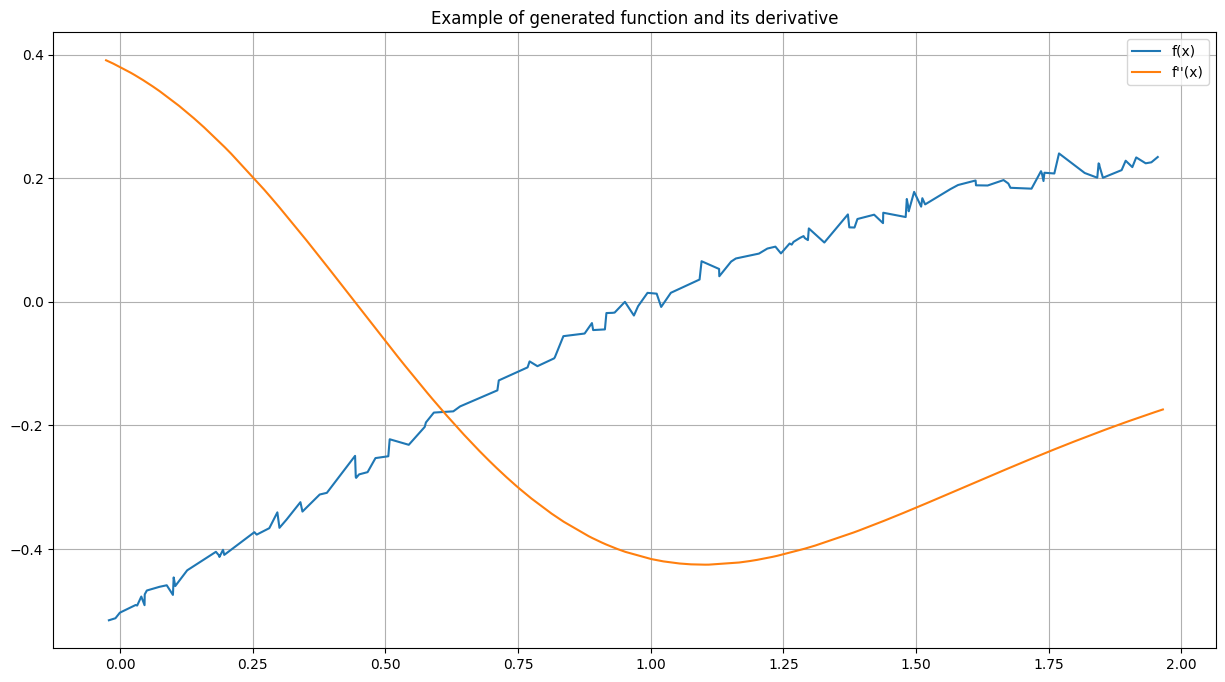

In [13]:
plt.figure(figsize=(15, 8))
plt.plot(i_p, f_e, label="f(x)")
plt.plot(o_p, ddf_e, label="f''(x)")
plt.grid()
plt.legend()
plt.title("Example of generated function and its derivative")
plt.show()

We define the total size of the dataset, and the resolution of the functions sampling. We noise the functions evaluations.

In [62]:
total_size = int(2**15)
length = 2
input_num_points = 64
output_num_points = 64
noise = 0.01

In [63]:
GENERATING = True# False

if GENERATING:
    print("Generating", total_size, "samples")
    x = se.Symbol('x')

    results = Parallel(n_jobs=-1)(delayed(generate_sample)(x, input_num_points, output_num_points, length, noise) for _ in tqdm(range(total_size)))

    functions, derivatives, input_points, output_points, functions_eval, derivatives_eval = zip(*results)

    X = np.array(list(zip(functions_eval, input_points)))
    Y = np.array(list(zip(derivatives_eval, output_points)))
    np.save("2nd_X.npy", X)
    np.save("2nd_Y.npy", Y)
else:
    X, Y = np.load("2nd_X.npy"), np.load("2nd_Y.npy")
    total_size, _, num_points = X.shape

Generating 32768 samples


  0%|          | 0/32768 [00:00<?, ?it/s]

In [64]:
device = 'cuda' if torch.cuda.is_available() else 'mps'

We split the dataset in three parts: half of it is the training set, and the two remaining quarters are for validation and testing.

In [65]:
train_size = int(X.shape[0]*0.5)
val_size = int(X.shape[0]*0.25)
test_size = X.shape[0] - train_size - val_size

x_train, y_train = torch.tensor(X[:train_size], dtype=torch.float32).to(device), torch.tensor(Y[:train_size], dtype=torch.float32).to(device)
x_val, y_val = torch.tensor(X[train_size:train_size+val_size], dtype=torch.float32).to(device), torch.tensor(Y[train_size:train_size+val_size], dtype=torch.float32).to(device)
x_test, y_test = torch.tensor(X[train_size+val_size:], dtype=torch.float32).to(device), torch.tensor(Y[train_size+val_size:], dtype=torch.float32).to(device)

We normalize the datasets using the minimum and maximum of the training set.

In [66]:
maxi_0 = x_train[:, 0].max()
mini_0 = x_train[:, 0].min()
maxi_1 = x_train[:, 1].max()
mini_1 = x_train[:, 1].min()

x_train[:, 0] = (x_train[:, 0]-mini_0)/(maxi_0-mini_0)
x_train[:, 1] = (x_train[:, 1]-mini_1)/(maxi_1-mini_1)

x_val[:, 0] = (x_val[:, 0]-mini_0)/(maxi_0-mini_0)
x_val[:, 1] = (x_val[:, 1]-mini_1)/(maxi_1-mini_1)

x_test[:, 0] = (x_test[:, 0]-mini_0)/(maxi_0-mini_0)
x_test[:, 1] = (x_test[:, 1]-mini_1)/(maxi_1-mini_1)

maxi_0_y = y_train[:, 0].max()
mini_0_y = y_train[:, 0].min()
maxi_1_y = y_train[:, 1].max()
mini_1_y = y_train[:, 1].min()

y_train[:, 0] = (y_train[:, 0]-mini_0_y)/(maxi_0_y-mini_0_y)
y_train[:, 1] = (y_train[:, 1]-mini_1_y)/(maxi_1_y-mini_1_y)

y_val[:, 0] = (y_val[:, 0]-mini_0_y)/(maxi_0_y-mini_0_y)
y_val[:, 1] = (y_val[:, 1]-mini_1_y)/(maxi_1_y-mini_1_y)

y_test[:, 0] = (y_test[:, 0]-mini_0_y)/(maxi_0_y-mini_0_y)
y_test[:, 1] = (y_test[:, 1]-mini_1_y)/(maxi_1_y-mini_1_y)

We define the three ML architectures.

In [67]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_shape, output_shape):
        super(NeuralNetwork, self).__init__()
        self.l1 = nn.Linear(input_shape, 512)
        self.l2 = nn.Linear(512, 256)
        self.l3 = nn.Linear(256, 128)
        self.l4 = nn.Linear(128, output_shape)
        
        self.relu = nn.ReLU()

    def forward(self, inputs, query):
        x = self.relu(self.l1(torch.concat([inputs.reshape((inputs.shape[0], -1)), query.reshape((query.shape[0], -1))], axis=1)))
        x = self.relu(self.l2(x))
        x = self.relu(self.l3(x))
        x = self.l4(x)
        return x

class CNN(nn.Module):
    def __init__(self, input_shape, output_shape):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv1d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * input_shape//4, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, output_shape)
        
        self.relu = nn.ReLU()

    def forward(self, inputs, query):
        x = self.relu(self.conv1(torch.concat([inputs.reshape((inputs.shape[0], 1, -1)), query.reshape((query.shape[0], 1, -1))], axis=2)))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.relu(self.conv3(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class NeuralOperator(nn.Module):
    def __init__(self, n_modes_height=64, n_layers=1, hidden_channels=16):
        super(NeuralOperator, self).__init__()
        self.fc = neuralop.models.FNO1d(n_modes_height=n_modes_height, n_layers=n_layers, in_channels=3, out_channels=1, hidden_channels=hidden_channels)

    def forward(self, inputs, query):
        inputs = inputs.view(inputs.size(0), -1, query.size(-1))
        return self.fc(torch.concat([inputs, query.unsqueeze(1)], 1)).squeeze(1)

In [68]:
torch.manual_seed(42)
neural_network = NeuralNetwork(input_num_points*2+output_num_points, output_num_points).to(device)
print("Neural Network:", np.sum([len(i) for i in neural_network.parameters()]), "parameters")

Neural Network: 1920 parameters


In [69]:
torch.manual_seed(42)
cnn = CNN(input_num_points*2+output_num_points, output_num_points).to(device)
print("Convolutional Neural Network:", np.sum([len(i) for i in cnn.parameters()]), "parameters")

Convolutional Neural Network: 1888 parameters


In [70]:
torch.manual_seed(42)
neural_operator = NeuralOperator(128, 4, 64).to(device)
print("Neural Operator:", np.sum([len(i) for i in neural_operator.parameters()]), "parameters")

Neural Operator: 1670 parameters


We define the training procedure.

In [71]:
def train(model, n_epochs, batch_size):
    best_model = deepcopy(model)
    criterion = nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)
    val_losses = []
    best_loss = np.inf
    for epoch in (pbar := tqdm(range(n_epochs))):
        model.train()
        for b in range(0, x_train.shape[0], batch_size):
            optimizer.zero_grad()
            predictions = model(x_train[b:b+batch_size], y_train[b:b+batch_size, 1])
            loss = criterion(predictions, y_train[b:b+batch_size, 0])
            loss.backward()
            optimizer.step()
        model.eval()
        with torch.no_grad():
            val_loss = criterion(model(x_val, y_val[:, 1]), y_val[:, 0]).item()
        val_losses.append(val_loss)
        scheduler.step(val_loss)
        pbar.set_description(f"Loss: {val_loss:.9f}")
        if val_loss < best_loss:
            best_loss = val_loss
            best_model = deepcopy(model)
    return best_model, val_losses

In [72]:
epochs = 128
batch_size = 128

In [73]:
TRAINING = True#False

In [74]:
if TRAINING:
    best_neural_operator, losses_neural_operator = train(neural_operator, epochs, batch_size)
    torch.save(best_neural_operator, "2nd_best_neural_operator.pt")
    np.save("2nd_losses_neural_operator.npy", losses_neural_operator)
else:
    best_neural_operator, losses_neural_operator = torch.load("2nd_best_neural_operator.pt", weights_only=False, map_location=device), np.load("2nd_losses_neural_operator.npy")

  0%|          | 0/128 [00:00<?, ?it/s]

In [75]:
if TRAINING:
    best_neural_network, losses_neural_network = train(neural_network, epochs, batch_size)
    torch.save(best_neural_network, "2nd_best_neural_network.pt")
    np.save("2nd_losses_neural_network.npy", losses_neural_network)
else:
    best_neural_network, losses_neural_network = torch.load("2nd_best_neural_network.pt", weights_only=False, map_location=device), np.load("2nd_losses_neural_network.npy")

  0%|          | 0/128 [00:00<?, ?it/s]

In [76]:
if TRAINING:
    best_cnn, losses_cnn = train(cnn, epochs, batch_size)
    torch.save(best_cnn, "2nd_best_cnn.pt")
    np.save("2nd_losses_cnn.npy", losses_cnn)
else:
    best_cnn, losses_cnn = torch.load("2nd_best_cnn.pt", weights_only=False, map_location=device), np.load("2nd_losses_cnn.npy")

  0%|          | 0/128 [00:00<?, ?it/s]

We evaluate the three ML architectures and the two numerical approaches.

In [77]:
with torch.no_grad():
    y_hat_nn = best_neural_network(x_test, y_test[:, 1]).to('cpu').squeeze().detach().numpy()
    y_hat_cnn = best_cnn(x_test, y_test[:, 1]).to('cpu').squeeze().detach().numpy()
    y_hat_no = best_neural_operator(x_test, y_test[:, 1]).to('cpu').squeeze().detach().numpy()

In [78]:
y_hat_cd = second_diff_central(((x_test[:, 0]*(maxi_0-mini_0))+mini_0).to('cpu'), ((x_test[:, 1]*(maxi_1-mini_1))+mini_1).to('cpu'), y_test[:, 1].to('cpu'))
y_hat_cd = (y_hat_cd-mini_0_y.item())/(maxi_0_y.item()-mini_0_y.item())

y_hat_si = second_diff_interpolate(((x_test[:, 0]*(maxi_0-mini_0))+mini_0).to('cpu'), ((x_test[:, 1]*(maxi_1-mini_1))+mini_1).to('cpu'), y_test[:, 1].to('cpu'))
y_hat_si = (y_hat_si-mini_0_y.item())/(maxi_0_y.item()-mini_0_y.item())

We show the predictions for $10$ samples of the testing set, w.r.t. the expected function.

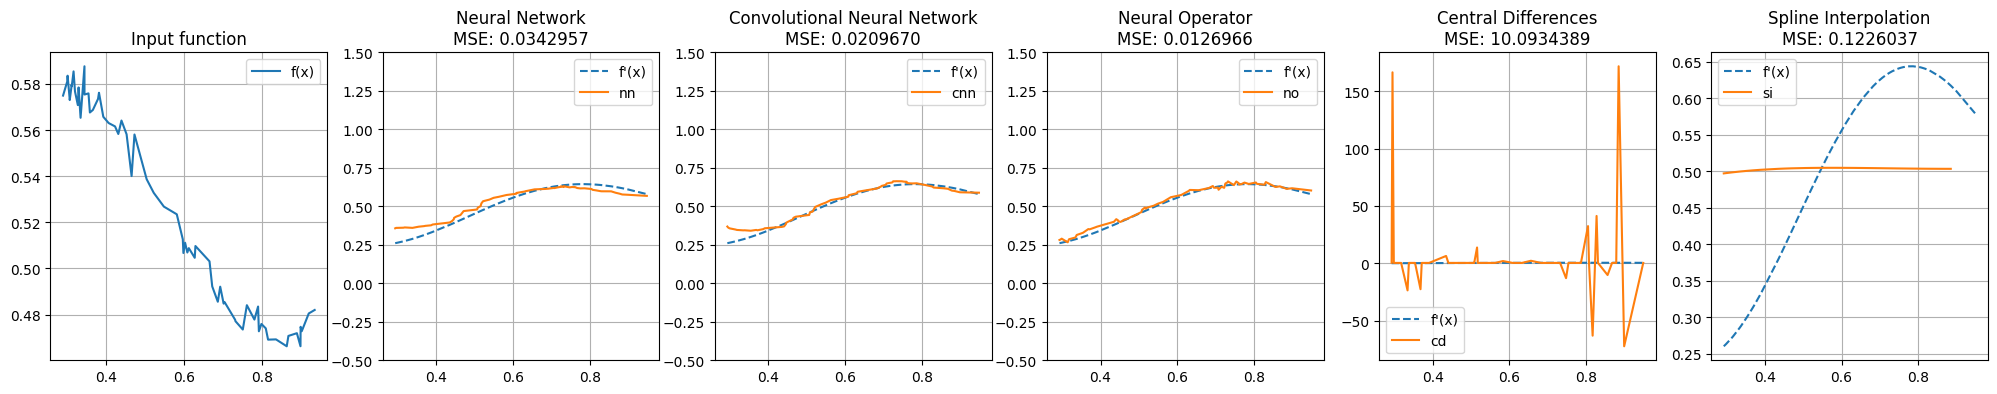

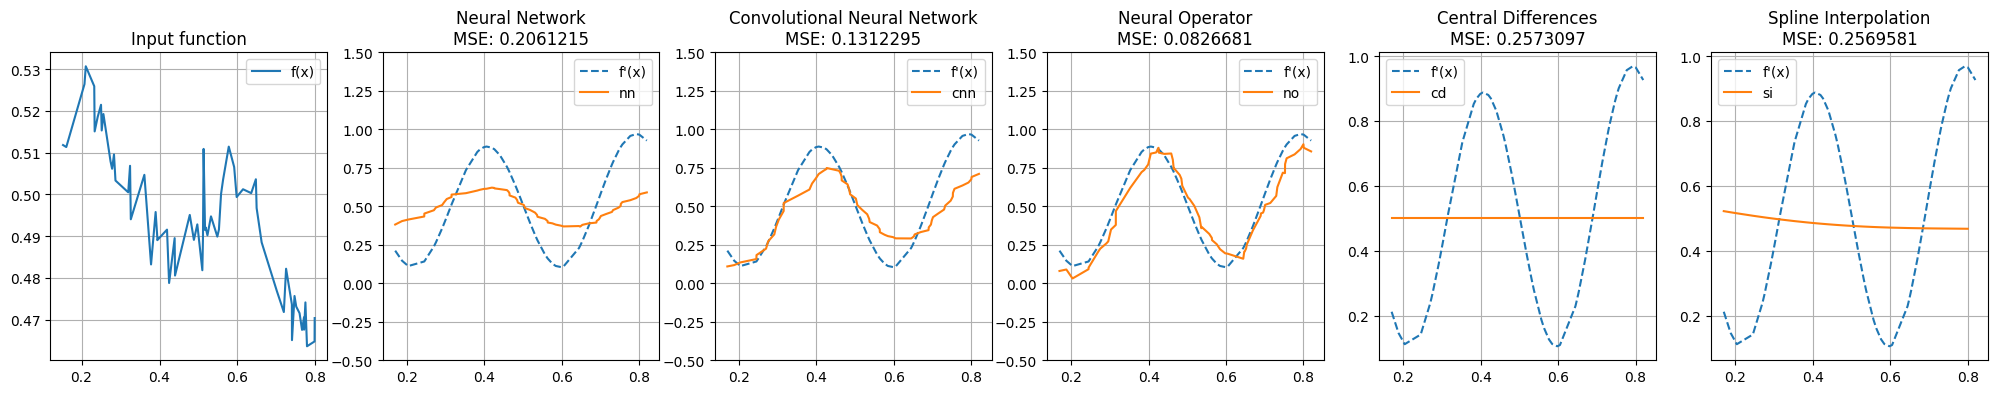

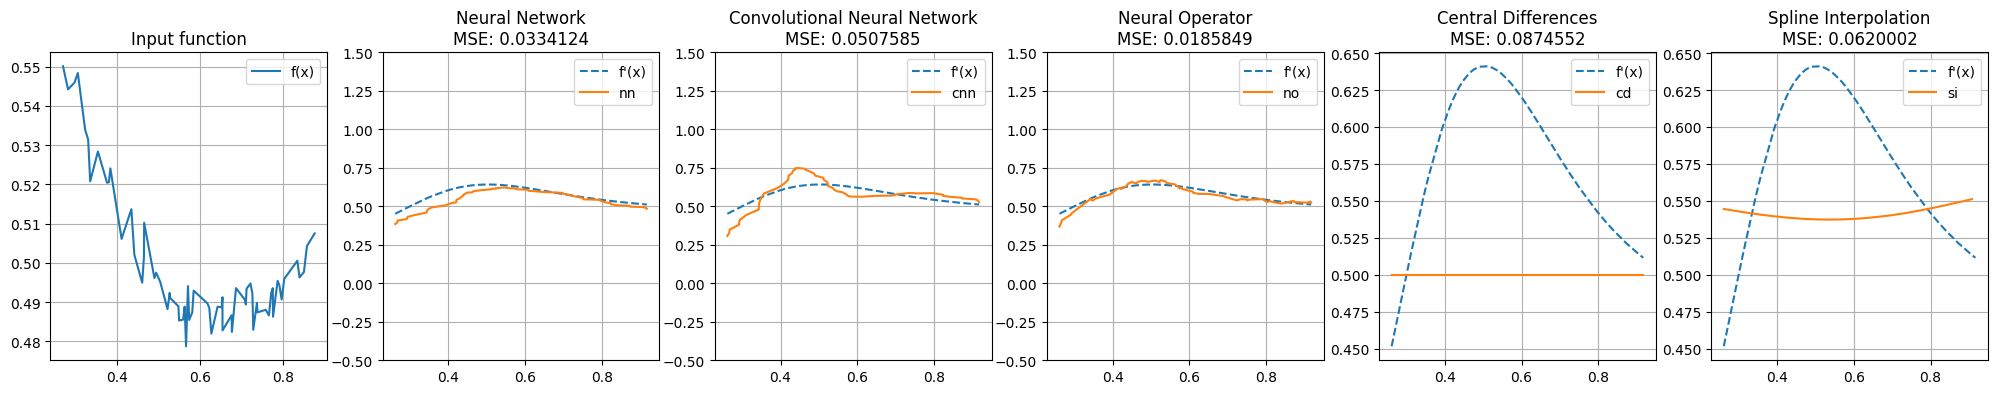

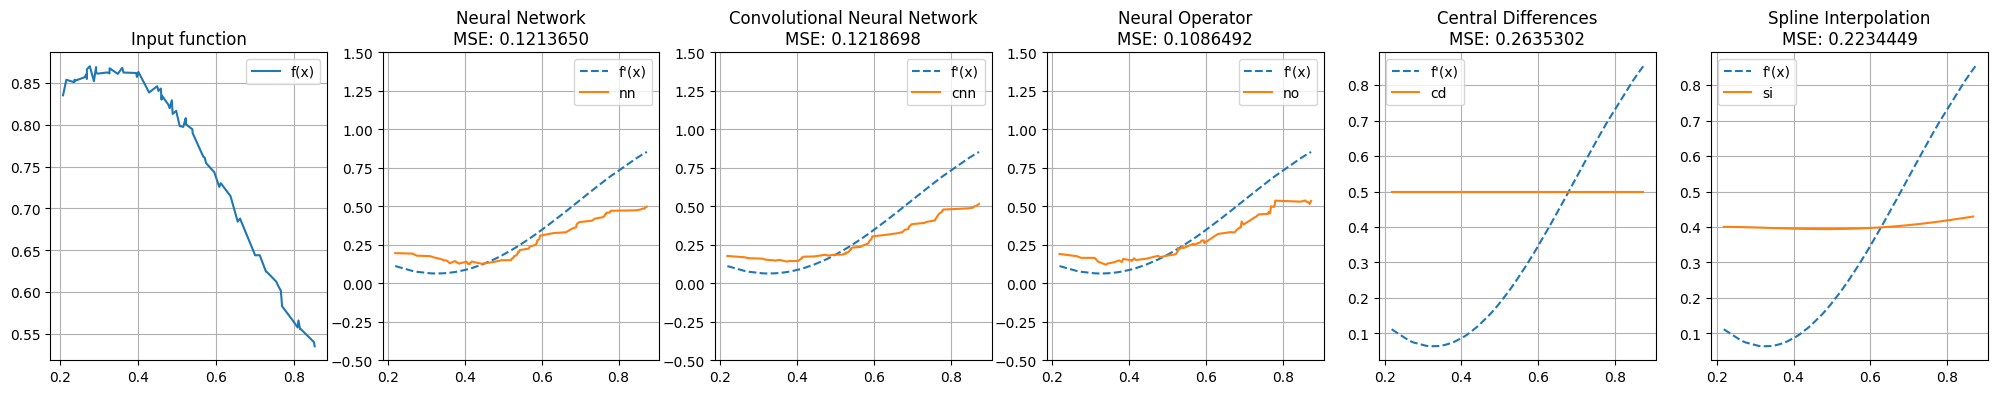

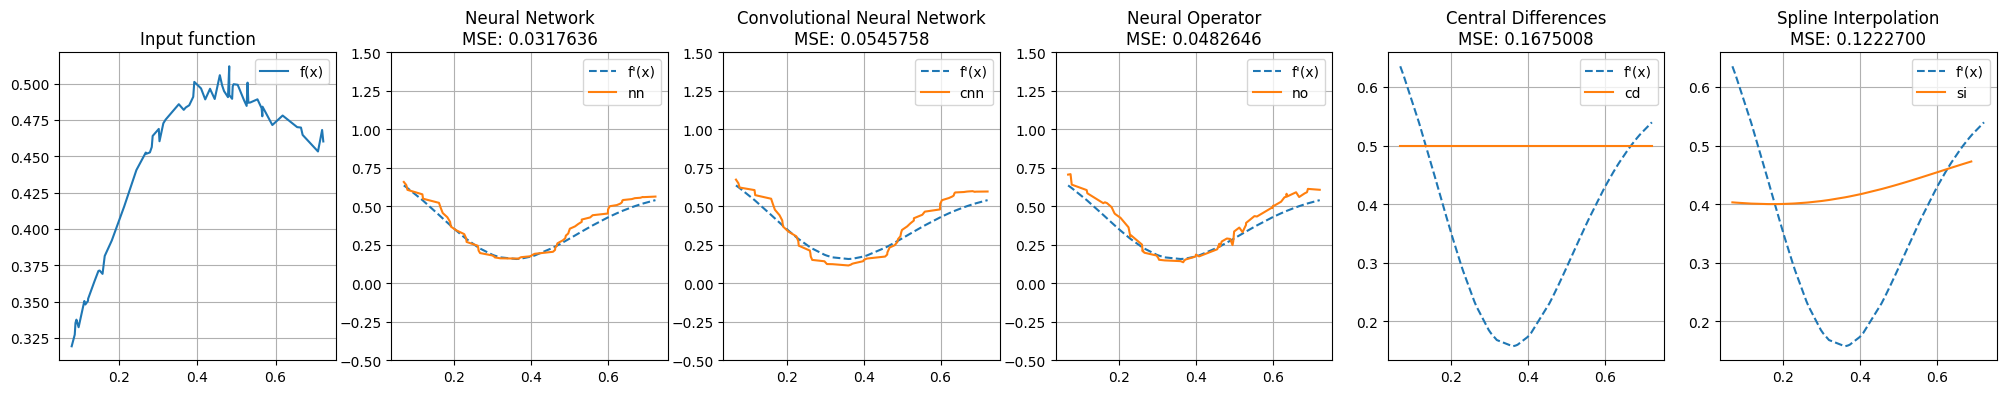

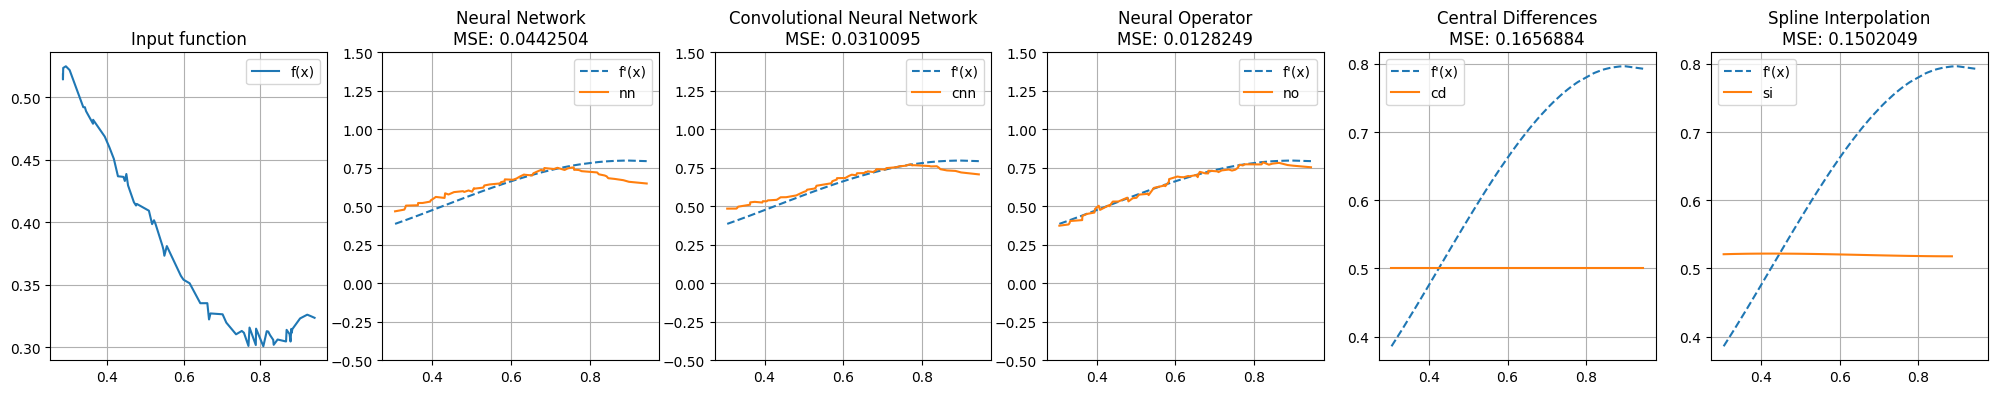

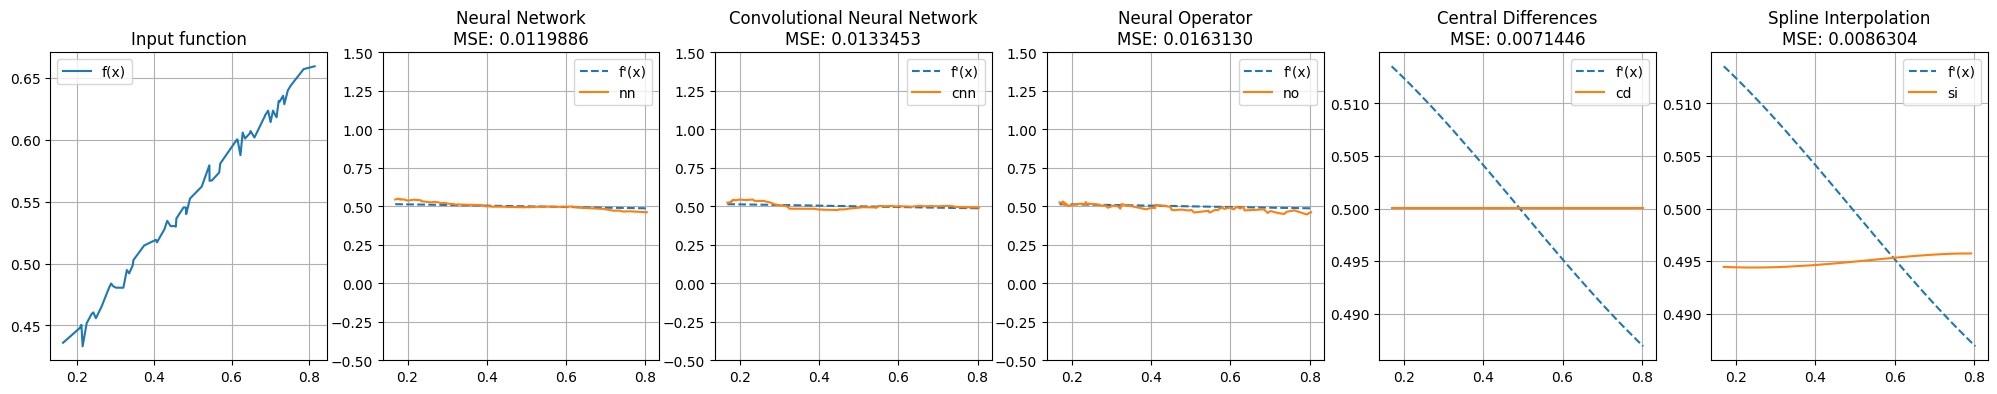

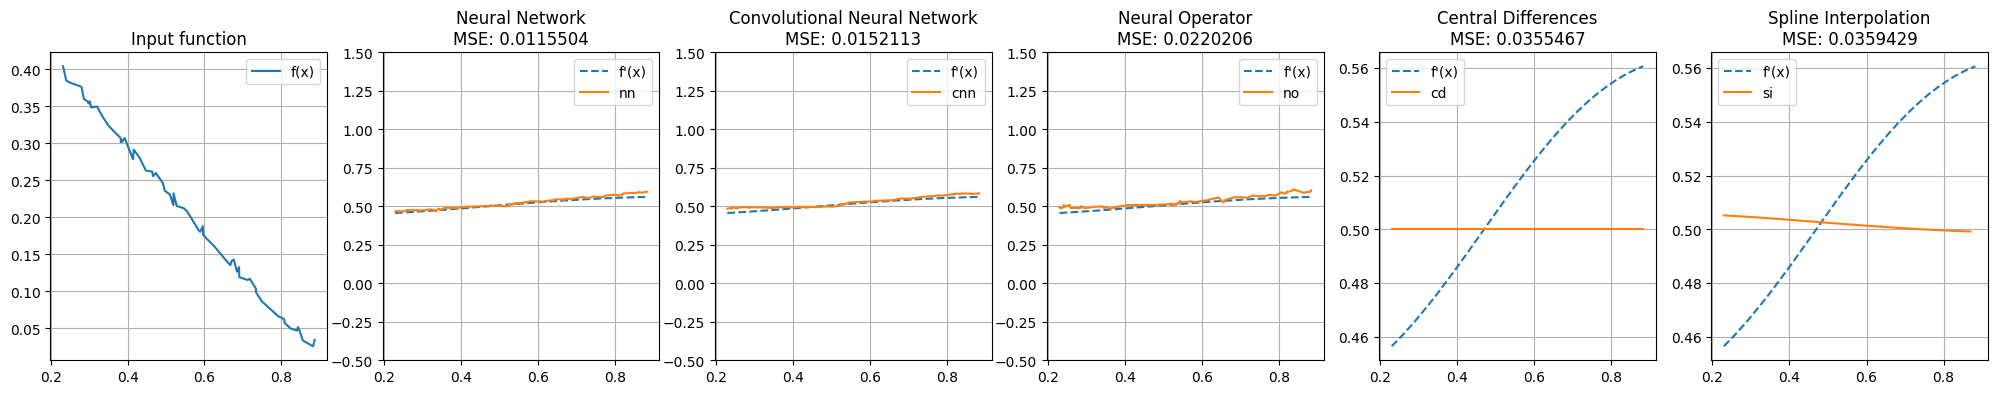

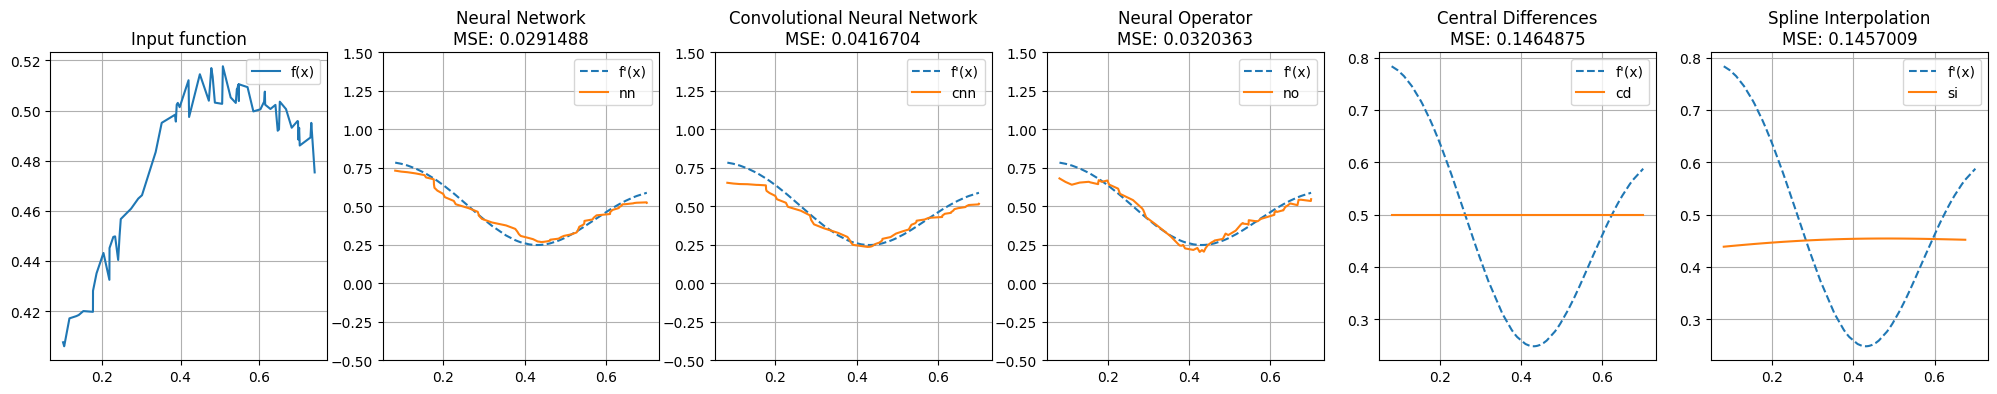

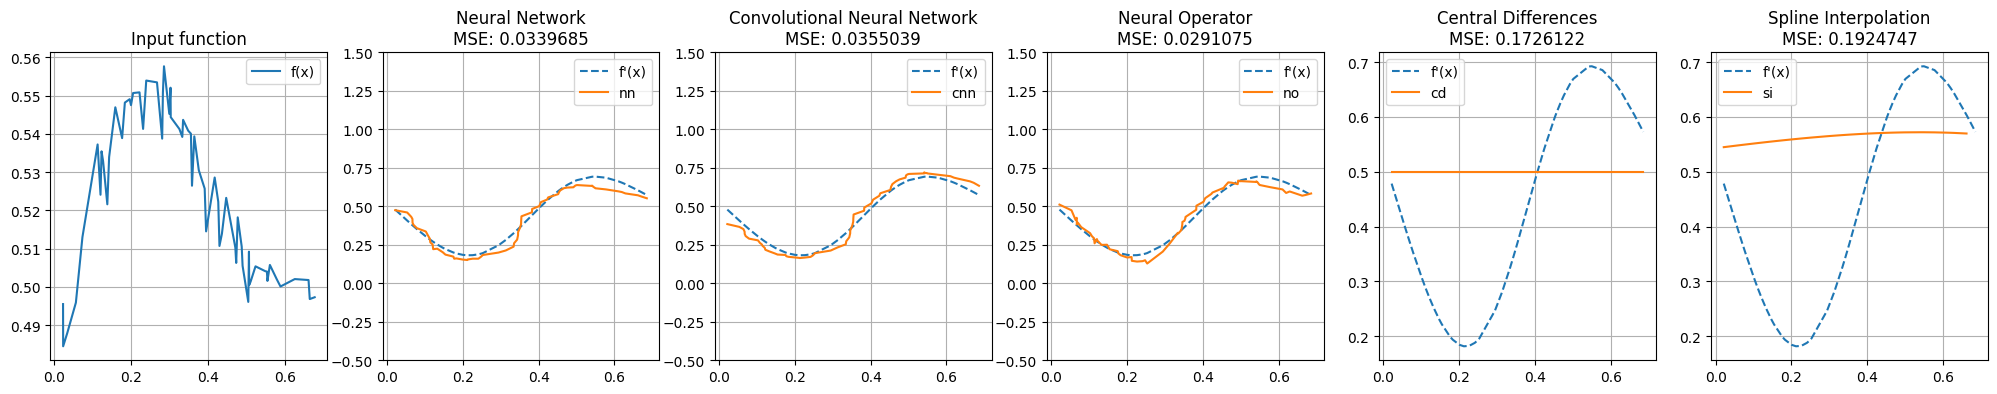

In [79]:
r = 0
errors = {"NN": [], "CNN": [], "NO": [], "CD": [], "SI": []}
n_samples = 10
for j in range(n_samples):
    i = r + j
    fig, ax = plt.subplots(1, 6, figsize=(25, 4))
    for a in range(5):
        ax[a+1].plot(y_test[i, 1].to("cpu"), y_test[i, 0].to("cpu"), linestyle="--", label="f'(x)")
    ax[0].plot(x_test[i, 1].to("cpu"), x_test[i, 0].to("cpu"), label='f(x)')
    ax[1].plot(y_test[i, 1].to("cpu"), y_hat_nn[i], label='nn')
    ax[2].plot(y_test[i, 1].to("cpu"), y_hat_cnn[i], label='cnn')
    ax[3].plot(y_test[i, 1].to("cpu"), y_hat_no[i], label='no')
    ax[4].plot(y_test[i, 1].to("cpu"), y_hat_cd[i], label='cd')
    ax[5].plot(y_test[i, 1, :-2].to("cpu"), y_hat_si[i], label='si')
    ax[0].set_title('Input function')
    errors["NN"].append(error(y_test[i, 0].to("cpu").numpy(), y_hat_nn[i]))
    errors["CNN"].append(error(y_test[i, 0].to("cpu").numpy(), y_hat_cnn[i]))
    errors["NO"].append(error(y_test[i, 0].to("cpu").numpy(), y_hat_no[i]))
    errors["CD"].append(error(y_test[i, 0].to("cpu").numpy(), y_hat_cd[i]))
    errors["SI"].append(error(y_test[i, 0, :-2].to("cpu").numpy(), y_hat_si[i]))
    ax[1].set_title(f'Neural Network\nMSE: {errors["NN"][-1]:.7f}')
    ax[2].set_title(f'Convolutional Neural Network\nMSE: {errors["CNN"][-1]:.7f}')
    ax[3].set_title(f'Neural Operator\nMSE: {errors["NO"][-1]:.7f}')
    ax[4].set_title(f'Central Differences\nMSE: {errors["CD"][-1]:.7f}')
    ax[5].set_title(f'Spline Interpolation\nMSE: {errors["SI"][-1]:.7f}')
    for a in range(1, 4):
        ax[a].set_ylim(-0.5, 1.5)
    for a in range(6):
        ax[a].legend()
        ax[a].grid('on')
    plt.show()

We compute the average prediction error for each procedure.

In [80]:
r = 0
errors = {"NN": [], "CNN": [], "NO": [], "CD": [], "SI": []}
n_samples = x_test.shape[0]
for j in range(n_samples):
    i = r + j
    errors["NN"].append(error(y_test[i, 0].to("cpu").numpy(), y_hat_nn[i]))
    errors["CNN"].append(error(y_test[i, 0].to("cpu").numpy(), y_hat_cnn[i]))
    errors["NO"].append(error(y_test[i, 0].to("cpu").numpy(), y_hat_no[i]))
    errors["CD"].append(error(y_test[i, 0].to("cpu").numpy(), y_hat_cd[i]))
    errors["SI"].append(error(y_test[i, 0, :-2].to("cpu").numpy(), y_hat_si[i]))
averages = {i: [np.mean(errors[i])] for i in errors}

In [81]:
for i in sorted(averages, key=lambda x: averages[x]):
    print(f"{i}:\t{averages[i][0]:.7f}")

NO:	0.0330290
CNN:	0.0386103
NN:	0.0452251
SI:	0.1165168
CD:	0.1296830


In [82]:
errors = pd.DataFrame(errors)
averages = pd.DataFrame(averages)

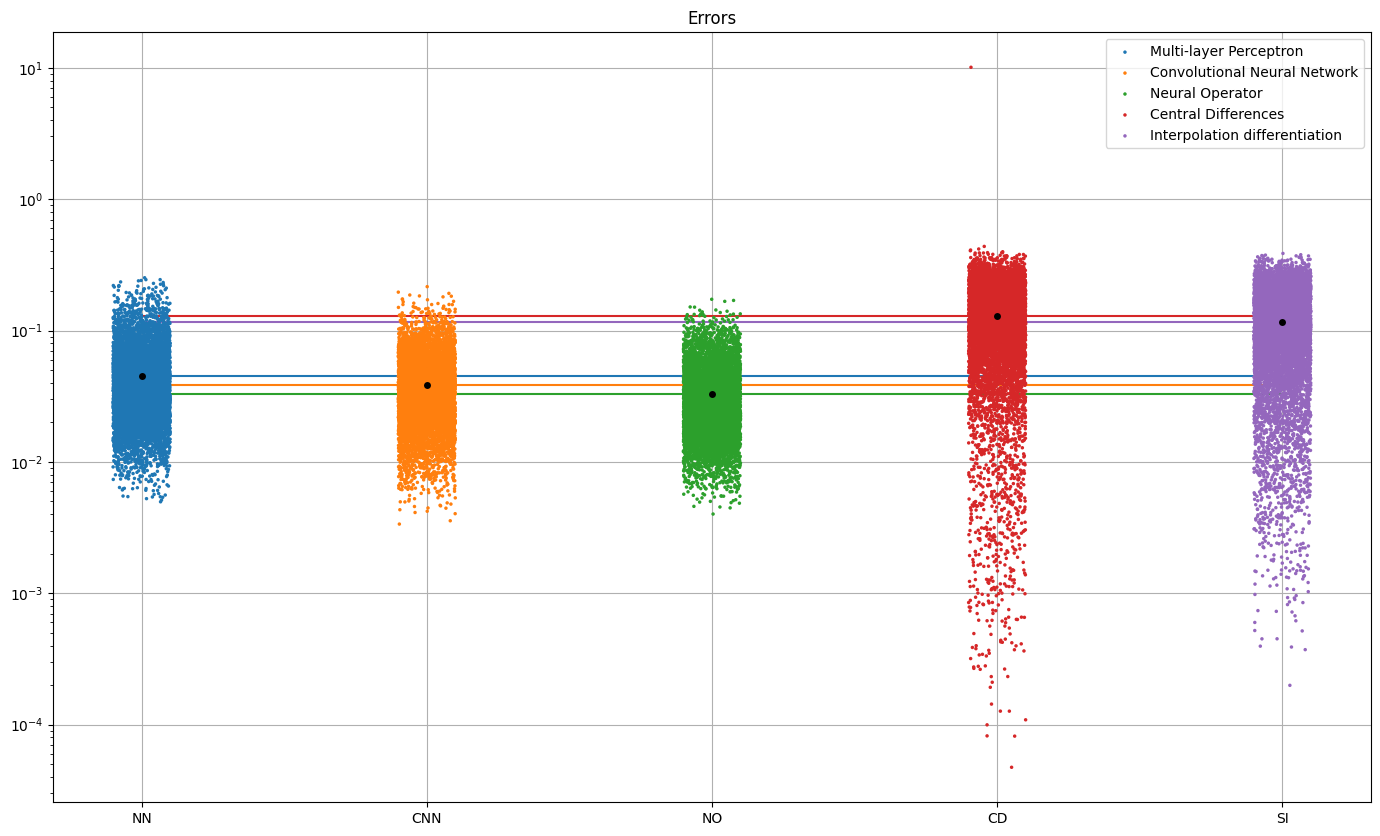

In [83]:
fig, ax = plt.subplots(figsize=(17, 10))
sns.stripplot(data=errors, ax=ax, marker='.')
sns.stripplot(data=averages, ax=ax, color='black', marker='o')
for i in averages:
    ax.plot([0, 4], [averages[i], averages[i]])
plt.legend(["Multi-layer Perceptron", "Convolutional Neural Network", "Neural Operator", "Central Differences", "Interpolation differentiation"])
plt.title("Errors")
plt.grid('on')
plt.yscale('log')
plt.show()